# Part A is copied here and minimized

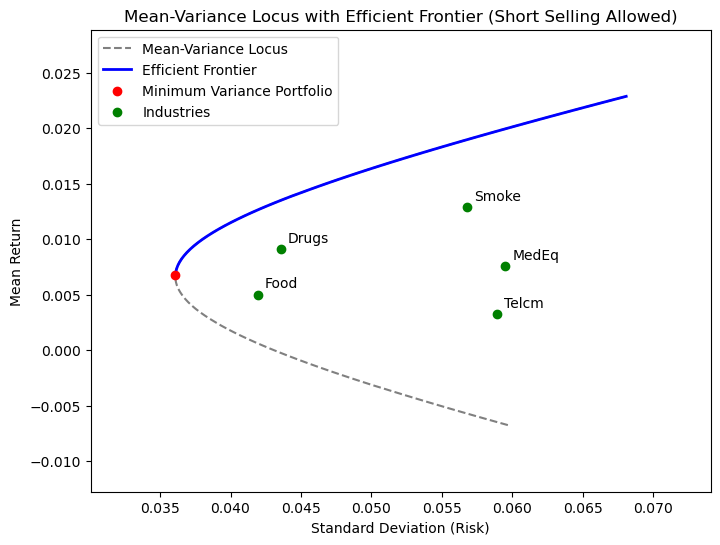

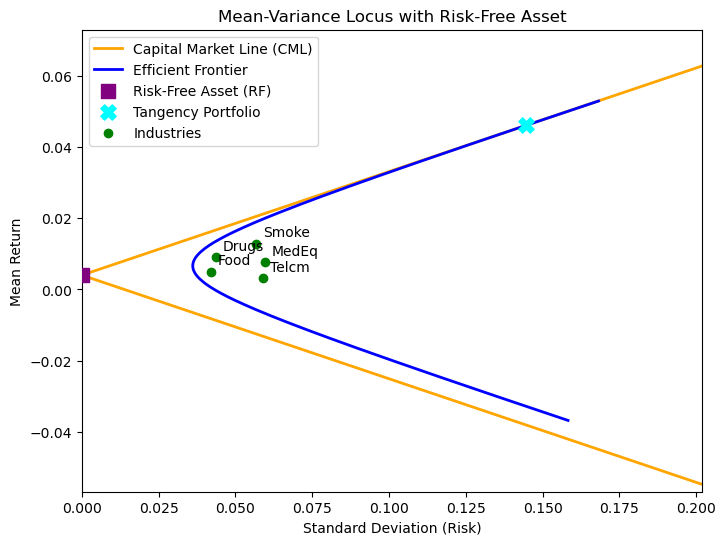


Tangency Portfolio Characteristics for Specified Graph:
    Characteristic    Value
   Expected Return 0.046030
          Variance 0.020911
Standard Deviation 0.144607

Tangency Portfolio Weights for Specified Graph:
         Weight
Food  -3.000123
Smoke  3.366369
MedEq  0.552711
Drugs  2.265163
Telcm -2.184119


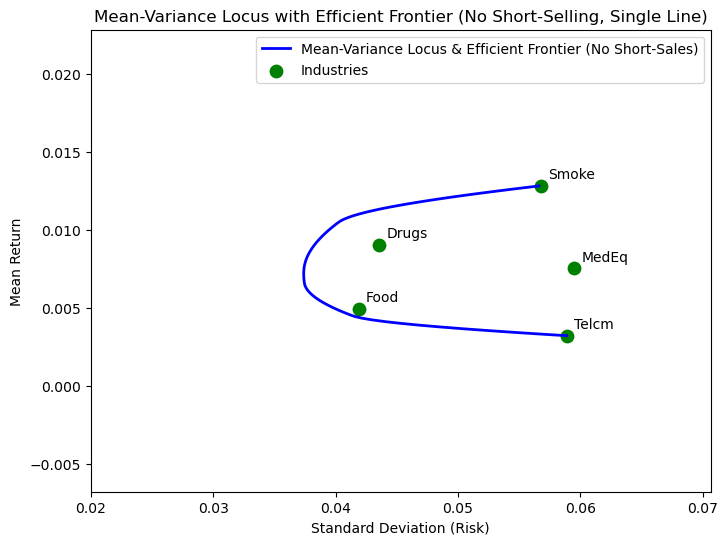

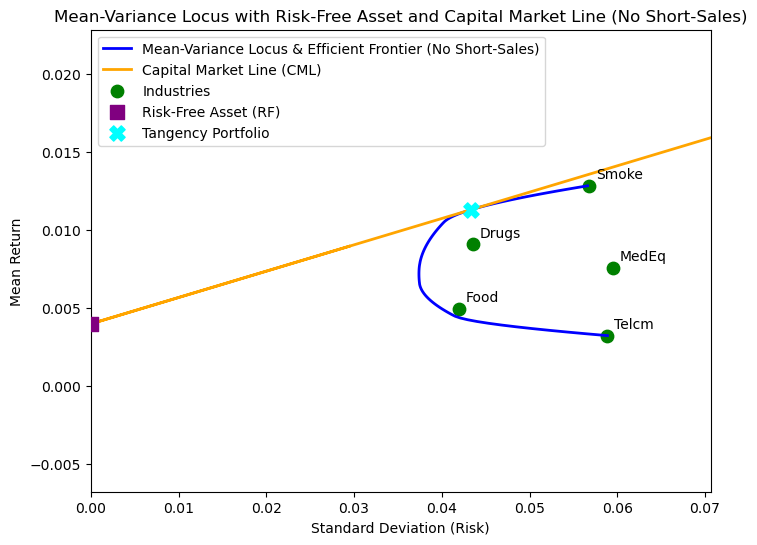


Tangency Portfolio Characteristics:
    Characteristic    Value
   Expected Return 0.011321
          Variance 0.001882
Standard Deviation 0.043377

Tangency Portfolio Weights:
         Weight
Food   0.000000
Smoke  0.592492
MedEq  0.000000
Drugs  0.407508
Telcm  0.000000


In [1]:
# %% [markdown]
# # Prepare Data

# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load new dataset
file_path = "Returns_Data_Cleaned.csv"  # Updated file path
df = pd.read_csv(file_path)

# Rename the first column (date column) properly
df.rename(columns={'Unnamed: 0': 'Dates'}, inplace=True)

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Filter for only the required industries
selected_industries = ["Food", "Smoke", "MedEq", "Drugs", "Telcm"]
df = df[["Dates"] + selected_industries]

# Convert Date column to DateTime format
df = df[df["Dates"].astype(str).str.match(r"^\d{6}$")]  # Keep only YYYYMM format
df["Dates"] = pd.to_datetime(df["Dates"], format="%Y%m")

# Filter data for the required date range
df_filtered = df[(df["Dates"] >= "2019-12-01") & (df["Dates"] <= "2024-11-01")]

# Convert returns from percentage format to decimal (divide by 100)
df_filtered.iloc[:, 1:] = df_filtered.iloc[:, 1:].div(100)

# Set Date as index
df_filtered.set_index("Dates", inplace=True)


# %% [markdown]
# # Part A

# %% [markdown]
# ## 1

# %%
# Recalculate mean returns and covariance matrix
mean_returns = df_filtered.mean()
cov_matrix = df_filtered.cov()

# Number of assets
num_assets = len(mean_returns)

# Initial guess for weights (equal distribution)
init_guess = np.ones(num_assets) / num_assets

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})

# No bounds (short selling allowed)
bounds = None

# Objective function: minimize portfolio variance
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Solve for minimum variance portfolio
min_var_result = minimize(portfolio_volatility, init_guess, args=(cov_matrix,), method='SLSQP',
                          constraints=constraints, bounds=bounds)

# Get minimum variance portfolio weights
min_var_weights = min_var_result.x
min_var_return = np.dot(min_var_weights, mean_returns)
min_var_std = portfolio_volatility(min_var_weights, cov_matrix)

# Generate full efficient frontier including short selling
target_returns = np.linspace(min(mean_returns) - 0.01, max(mean_returns) + 0.01, 100)  # Expanded Y range
efficient_risks = []

for target in target_returns:
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target})

    result = minimize(portfolio_volatility, init_guess, args=(cov_matrix,), method='SLSQP',
                      constraints=constraints, bounds=bounds)

    efficient_risks.append(result.fun)

# Identify the efficient part (upper part of the parabola)
efficient_idx = np.argmax(target_returns > min_var_return)  # Index where frontier becomes efficient
efficient_risks_upper = efficient_risks[efficient_idx:]
target_returns_upper = target_returns[efficient_idx:]

# Plot full mean-variance locus with expanded view
plt.figure(figsize=(8, 6))
plt.plot(efficient_risks, target_returns, label="Mean-Variance Locus", color="gray", linestyle="dashed")
plt.plot(efficient_risks_upper, target_returns_upper, label="Efficient Frontier", color="blue", linewidth=2)
plt.scatter(min_var_std, min_var_return, color="red", label="Minimum Variance Portfolio", zorder=3)
plt.scatter(df_filtered.std(), mean_returns, marker='o', color='green', label="Industries")

# Annotate each industry point
for industry, x, y in zip(df_filtered.columns, df_filtered.std(), mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5,5), textcoords="offset points")

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontier (Short Selling Allowed)")

# Expand axis limits for better visualization
plt.xlim(min(efficient_risks) - 0.006, max(efficient_risks) + 0.006)  # Expanded X range
plt.ylim(min(target_returns) - 0.006, max(target_returns) + 0.006)  # Expanded Y range

plt.legend()
plt.grid(False)

# Show the plot
plt.show()


# %% [markdown]
# ## 2

# %%
# Define the risk-free rate (monthly return)
rf = 0.004  # 0.4% risk-free rate per month

# Compute the inverse of the covariance matrix
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Compute the excess returns (mean returns - risk-free rate)
excess_returns = mean_returns - rf

# Compute the tangency portfolio weights: w* = inv(Σ) * (mean - rf) / sum(inv(Σ) * (mean - rf))
ones = np.ones(num_assets)
tangency_weights = inv_cov_matrix @ excess_returns / (ones.T @ inv_cov_matrix @ excess_returns)

# Compute tangency portfolio return and standard deviation
tangency_return = np.dot(tangency_weights, mean_returns)
tangency_std = np.sqrt(np.dot(tangency_weights.T, np.dot(cov_matrix, tangency_weights)))

# Generate extended efficient frontier including a wider range of returns
target_returns_extended = np.linspace(min(mean_returns) - 0.04, max(mean_returns) + 0.04, 200)
efficient_risks_extended = []

for target in target_returns_extended:
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target})

    result = minimize(lambda w: np.sqrt(np.dot(w.T, np.dot(cov_matrix, w))), init_guess, method='SLSQP',
                      constraints=constraints, bounds=bounds)

    efficient_risks_extended.append(result.fun)

# Ensure standard deviation values remain positive
efficient_risks_extended = np.abs(efficient_risks_extended)

# Generate the correct Capital Market Line (CML) as a continuous line
cml_risk = np.linspace(0, max(efficient_risks_extended) * 1.5, 300)
cml_return = rf + ((tangency_return - rf) / tangency_std) * np.concatenate((-cml_risk[::-1], cml_risk))

# Align standard deviations with mean returns to ensure same size
industry_std = df_filtered.std()[mean_returns.index]

# Plot Mean-Variance Locus with Extended Efficient Frontier and Corrected CML
plt.figure(figsize=(8, 6))

# Capital Market Line (CML) as a continuous line
plt.plot(np.concatenate((cml_risk[::-1], cml_risk)), cml_return, label="Capital Market Line (CML)", color="orange", linewidth=2)

# Extended Efficient Frontier (including full parabola)
plt.plot(efficient_risks_extended, target_returns_extended, label="Efficient Frontier", color="blue", linewidth=2)

# Plot risk-free asset, tangency portfolio, and individual industries
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)
plt.scatter(tangency_std, tangency_return, color="cyan", label="Tangency Portfolio", zorder=3, marker="X", s=120)  # Changed color to cyan
plt.scatter(industry_std, mean_returns, marker='o', color='green', label="Industries")

# Annotate each industry point
for industry, x, y in zip(mean_returns.index, industry_std, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5,5), textcoords="offset points")

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Risk-Free Asset")

# Adjust axis limits for better visualization
plt.xlim(0, max(efficient_risks_extended) * 1.2)  # Standard deviation always positive
plt.ylim(min(target_returns_extended) - 0.02, max(target_returns_extended) + 0.02)  # Expanded Y range

plt.legend()
plt.grid(False)

# Show the corrected plot
plt.show()

# %% [markdown]
# ## 3

# %%
# Compute the Tangency Portfolio characteristics with 6 decimal places for the specified graph
tangency_expected_return = round(tangency_return, 6)  # Expected return of the Tangency Portfolio
tangency_variance = round(tangency_std ** 2, 6)  # Variance of the Tangency Portfolio
tangency_std_rounded = round(tangency_std, 6)  # Standard Deviation of the Tangency Portfolio

# Create a DataFrame for Tangency Portfolio characteristics
tangency_portfolio_info = pd.DataFrame({
    "Characteristic": ["Expected Return", "Variance", "Standard Deviation"],
    "Value": [tangency_expected_return, tangency_variance, tangency_std_rounded]
})

# Create a DataFrame for Tangency Portfolio Weights with 6 decimal places
tangency_weights_df = pd.DataFrame(tangency_weights, index=mean_returns.index, columns=["Weight"])
tangency_weights_df = tangency_weights_df.round(6)

# Display the Tangency Portfolio characteristics and weights
print("\nTangency Portfolio Characteristics for Specified Graph:")
print(tangency_portfolio_info.to_string(index=False))

print("\nTangency Portfolio Weights for Specified Graph:")
print(tangency_weights_df.to_string())

# %% [markdown]
# ## 4

# %%
# Function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Modify the efficient frontier to include short-sale constraints (weights must be non-negative)
bounds = [(0, 1)] * num_assets  # No short-selling allowed

# Generate efficient frontier with short-sale constraints
target_returns_no_short = np.linspace(min(mean_returns) - 0, max(mean_returns) + 0.012857, 200)
efficient_risks_no_short = []

for target in target_returns_no_short:
    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - target})

    result = minimize(portfolio_volatility, init_guess, args=(cov_matrix,), method='SLSQP',
                      constraints=constraints, bounds=bounds)

    efficient_risks_no_short.append(result.fun)

# Identify the efficient part (upper part of the parabola)
efficient_idx_no_short = np.argmax(target_returns_no_short > min_var_return)  # Index where frontier becomes efficient
efficient_risks_upper_no_short = efficient_risks_no_short[efficient_idx_no_short:]
target_returns_upper_no_short = target_returns_no_short[efficient_idx_no_short:]

# Define the cutoff points for the efficient frontier and mean-variance locus
max_return_limit = max(mean_returns["Smoke"], mean_returns["Telcm"])

# Filter the efficient frontier data to stop at the maximum return limit
valid_indices = target_returns_no_short <= max_return_limit
efficient_risks_no_short_limited = np.array(efficient_risks_no_short)[valid_indices]
target_returns_no_short_limited = np.array(target_returns_no_short)[valid_indices]

# Find the new efficient frontier part (upper portion)
efficient_idx_no_short_limited = np.argmax(target_returns_no_short_limited > min_var_return)
efficient_risks_upper_no_short_limited = efficient_risks_no_short_limited[efficient_idx_no_short_limited:]
target_returns_upper_no_short_limited = target_returns_no_short_limited[efficient_idx_no_short_limited:]

# Ensure standard deviations and mean returns have the same size
industry_std_no_short = df_filtered.std()[mean_returns.index]

# Plot the adjusted mean-variance locus with short-sale constraints as a single line
plt.figure(figsize=(8, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Line)
plt.plot(efficient_risks_no_short_limited, target_returns_no_short_limited, 
         label="Mean-Variance Locus & Efficient Frontier (No Short-Sales)", color="blue", linewidth=2)

# Industry points (Green Dots)
plt.scatter(industry_std_no_short, mean_returns, marker='o', color='green', label="Industries", s=80)

# Annotate each industry point correctly
for industry, x, y in zip(mean_returns.index, industry_std_no_short, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5,5), textcoords="offset points")

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Efficient Frontier (No Short-Selling, Single Line)")

# Adjust axis limits to properly align the graph
plt.xlim(0.02, max(efficient_risks_no_short_limited) * 1.2)  # Ensuring standard deviation remains positive
plt.ylim(min(target_returns_no_short_limited) - 0.01, max_return_limit + 0.01)  # Properly centered Y range

plt.legend()
plt.grid(False)

# Show the corrected plot
plt.show()

# %% [markdown]
# ## 5

# %%
# Function to calculate portfolio volatility
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Adjust mean returns to be in excess return form (subtract risk-free rate)
mean_returns_excess = mean_returns - rf

# Generate efficient frontier with short-sale constraints in excess return form
target_returns_no_short_rf = np.linspace(min(mean_returns_excess), max(mean_returns_excess) + 0.012857, 200)
efficient_risks_no_short_rf = []

# Solve for each target return in excess return space
for target in target_returns_no_short_rf:
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
                   {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns_excess) - target}]

    result = minimize(lambda w: portfolio_volatility(w, cov_matrix), init_guess, method='SLSQP',
                      constraints=constraints, bounds=bounds)

    if result.success:
        efficient_risks_no_short_rf.append(result.fun)
    else:
        efficient_risks_no_short_rf.append(np.nan)  # Replace failed optimizations with NaN

# Convert lists to numpy arrays and filter out NaN values
efficient_risks_no_short_rf = np.array(efficient_risks_no_short_rf)
target_returns_no_short_rf = np.array(target_returns_no_short_rf)

valid_indices_rf = ~np.isnan(efficient_risks_no_short_rf)
efficient_risks_no_short_rf = efficient_risks_no_short_rf[valid_indices_rf]
target_returns_no_short_rf = target_returns_no_short_rf[valid_indices_rf]

# Define the cutoff points for the efficient frontier
max_return_limit_rf = max(mean_returns_excess["Smoke"], mean_returns_excess["Telcm"])

# Filter the efficient frontier data to stop at the maximum return limit
valid_indices_rf = target_returns_no_short_rf <= max_return_limit_rf
efficient_risks_no_short_limited_rf = efficient_risks_no_short_rf[valid_indices_rf]
target_returns_no_short_limited_rf = target_returns_no_short_rf[valid_indices_rf]

# Ensure standard deviations and mean returns have the same size
industry_std_no_short_rf = df_filtered.std()[mean_returns.index]

# Compute the Tangency Portfolio using the Sharpe Ratio maximization
def objective_sharpe(w, mean_returns, cov_matrix, rf):
    portfolio_return = np.dot(w, mean_returns)  # Portfolio expected return (absolute return)
    portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))  # Portfolio risk (volatility)
    sharpe_ratio = (portfolio_return - rf) / portfolio_volatility  # Sharpe ratio
    return -sharpe_ratio  # Maximize Sharpe Ratio by minimizing its negative

# Constraint: sum of weights = 1
constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]

# Optimize for the tangency portfolio weights
result_tangency = minimize(objective_sharpe, init_guess, args=(mean_returns, cov_matrix, rf), 
                           bounds=bounds, constraints=constraints)

# Extract optimal weights and compute tangency portfolio return and risk
if result_tangency.success:
    optimal_weights = result_tangency.x
    tangency_return = np.dot(optimal_weights, mean_returns)  # Tangency Portfolio return (absolute return)
    tangency_std = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))  # Tangency Portfolio risk

# Generate the extended Capital Market Line (CML)
cml_risk = np.linspace(-max(efficient_risks_no_short_limited_rf) * 0.5, max(efficient_risks_no_short_limited_rf) * 1.5, 300)  
cml_risk = np.abs(cml_risk)  # Ensure standard deviation remains positive
cml_return = rf + ((tangency_return - rf) / tangency_std) * cml_risk  # CML equation with correct RF intercept

# Plot Mean-Variance Locus with Risk-Free Asset (No Short-Sales) and Extended CML
plt.figure(figsize=(8, 6))

# Combined Mean-Variance Locus and Efficient Frontier (Single Line with RF Adjustment)
plt.plot(efficient_risks_no_short_limited_rf, target_returns_no_short_limited_rf + rf, 
         label="Mean-Variance Locus & Efficient Frontier (No Short-Sales)", color="blue", linewidth=2)

# Capital Market Line (CML) fully extended
plt.plot(cml_risk, cml_return, label="Capital Market Line (CML)", color="orange", linewidth=2)

# Industry points (Green Dots) in absolute return form
plt.scatter(industry_std_no_short_rf, mean_returns, marker='o', color='green', label="Industries", s=80)

# Annotate each industry point correctly
for industry, x, y in zip(mean_returns.index, industry_std_no_short_rf, mean_returns):
    plt.annotate(industry, (x, y), fontsize=10, xytext=(5,5), textcoords="offset points")

# Plot Risk-Free Asset at (0, RF) instead of (0,0)
plt.scatter(0, rf, color="purple", label="Risk-Free Asset (RF)", zorder=3, marker="s", s=100)

# Plot Tangency Portfolio at the optimal risk-return tradeoff
plt.scatter(tangency_std, tangency_return, color="cyan", label="Tangency Portfolio", zorder=3, marker="X", s=120)

# Labels and title
plt.xlabel("Standard Deviation (Risk)")
plt.ylabel("Mean Return")
plt.title("Mean-Variance Locus with Risk-Free Asset and Capital Market Line (No Short-Sales)")

# Adjust axis limits for proper visualization
plt.xlim(0, max(efficient_risks_no_short_limited_rf) * 1.2)  # Ensuring standard deviation remains positive
plt.ylim(min(target_returns_no_short_limited_rf) + rf - 0.01, max(target_returns_no_short_limited_rf) + rf + 0.01)  # Properly centered Y range

plt.legend()
plt.grid(False)

# Show the corrected plot
plt.show()


# %% [markdown]
# ## 6

# %%
# Compute the Tangency Portfolio characteristics with 6 decimal places
tangency_expected_return = round(tangency_return, 6)  # Expected return of the Tangency Portfolio
tangency_variance = round(tangency_std ** 2, 6)  # Variance of the Tangency Portfolio
tangency_std_rounded = round(tangency_std, 6)  # Standard Deviation of the Tangency Portfolio

# Create a DataFrame for Tangency Portfolio characteristics
tangency_portfolio_info = pd.DataFrame({
    "Characteristic": ["Expected Return", "Variance", "Standard Deviation"],
    "Value": [tangency_expected_return, tangency_variance, tangency_std_rounded]
})

# Create a DataFrame for Tangency Portfolio Weights with 6 decimal places
tangency_weights_df = pd.DataFrame(optimal_weights, index=mean_returns.index, columns=["Weight"])
tangency_weights_df = tangency_weights_df.round(6)

# Display the Tangency Portfolio characteristics and weights
print("\nTangency Portfolio Characteristics:")
print(tangency_portfolio_info.to_string(index=False))

print("\nTangency Portfolio Weights:")
print(tangency_weights_df.to_string())

# %% [markdown]
# # Part B

# %% [markdown]
# 




# Start Here

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold

In [2]:
# Load the data for 10 years
file_path = "Returns_Data_Cleaned.csv"
df_10 = pd.read_csv(file_path)
returns_data_10 = df_10.iloc[:, 1:]  # Remove the date column and keep only the returns data

In [3]:
# Set parameters
num_assets = returns_data_10.shape[1]  # Total number of assets
num_subpools = 1000  # Number of generated subpools
subpool_size = 10  # Size of each selected subpool, N
T = returns_data_10.shape[0]  # Time window (number of samples)

# Define the risk-free rate (monthly return)
rf = 0.4  # 0.4% risk-free rate per month

# Calculate excess returns, r
r = returns_data_10 - rf

In [7]:
# Function to compute θs, μ̂' Σ̂^(-1) μ̂
def compute_theta_s(mu, sigma_inv):
    return mu.T @ sigma_inv @ mu

In [9]:
# Function to compute θadj
def adjusted_sharpe_ratio(theta_s, N, T):
    from scipy.special import betainc
    
    # Compute the Beta incomplete function
    B_x_value = betainc(N / 2, (T - N) / 2, theta_s / (1 + theta_s))
    
    # Compute the adjustment term
    adjustment_term = (2 * (theta_s ** (N/2)) * (1 + theta_s) ** (-(T-2)/2)) / (T * B_x_value)
    
    # Compute θ̂_adj
    theta_adj = ((T - N - 2) * theta_s - N) / T + adjustment_term
    
    return theta_adj  # Return both θ_adj and the adjustment term

In [11]:
# Perform subpool selection
subpool_results = []

for _ in range(num_subpools):
    # Randomly select a subset of assets (without replacement)
    selected_assets = np.random.choice(r.columns, subpool_size, replace=False)
    
    # Compute mean return (μ̂) and covariance matrix (Σ̂) for the selected subpool
    mu_subpool = r[selected_assets].mean().values  # Estimated mean returns, μ̂
    sigma_subpool = r[selected_assets].cov().values  # Estimated covariance matrix, Σ̂
    
    # Compute the inverse of the covariance matrix Σ̂^(-1)
    sigma_inv = np.linalg.pinv(sigma_subpool)
    
    # Compute θ̂_s using the formula: θ̂_s := μ̂' Σ̂^(-1) μ̂
    theta_s = compute_theta_s(mu_subpool, sigma_inv)

    # Compute θ̂
    theta = ((T - subpool_size - 2) * theta_s - subpool_size) / T

    # Compute θ̂_adj
    theta_adj= adjusted_sharpe_ratio(theta_s, subpool_size, T)
    
    # Store selected assets, θ̂_s, and corresponding θ̂_adj value
    subpool_results.append((selected_assets.tolist(), theta, theta_s, theta_adj))

# Extract θ̂_s and θ̂_adj values separately
theta_values = np.array([x[1] for x in subpool_results])
theta_s_values = np.array([x[2] for x in subpool_results])
theta_adj_values = np.array([x[3] for x in subpool_results])

# Compute the 95% quantile of θ̂_s values
theta_adj_95_quantile = np.percentile(theta_adj_values, 95)

# Find the subpool closest to the 95% quantile
best_subpool = min(subpool_results, key=lambda x: abs(x[1] - theta_adj_95_quantile))[0]  # Get the selected assets

In [13]:
theta_adj_95_quantile

0.08667411553505282

In [15]:
best_subpool

['BldMt',
 'Mach ',
 'Smoke',
 'Hlth ',
 'Telcm',
 'Rtail',
 'Rubbr',
 'Chems',
 'Insur',
 'Comps']

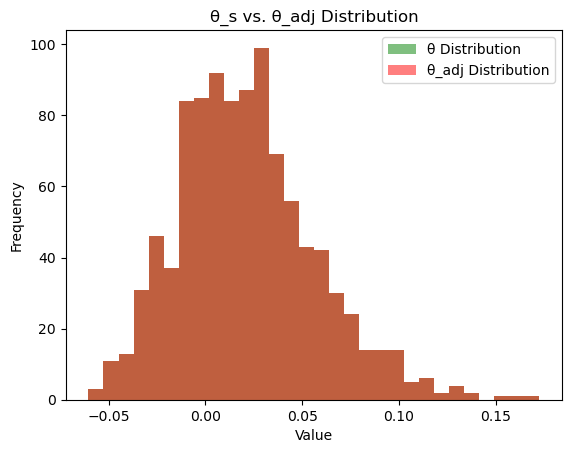

In [17]:
import numpy as np
import matplotlib.pyplot as plt

plt.hist(theta_values, bins=30, alpha=0.5, label="θ Distribution", color='green')
#plt.hist(theta_s_values, bins=30, alpha=0.5, label="θ_s Distribution", color='blue')
plt.hist(theta_adj_values, bins=30, alpha=0.5, label="θ_adj Distribution", color='red')
#plt.axvline(theta_adj_95_quantile, color='black', linestyle='dashed', label="95% θ_adj Quantile")
plt.legend()
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("θ_s vs. θ_adj Distribution")
plt.show()

In [19]:
print(f"Min θ_s: {np.min(theta_adj_values)}")
print(f"Mean θ_s: {np.mean(theta_adj_values)}")
print(f"Max θ_s: {np.max(theta_adj_values)}")

Min θ_s: -0.0604295779830859
Mean θ_s: 0.021407875921140747
Max θ_s: 0.17243185318355153


In [21]:
### problem 1: theta_adj存在负值, adjustment term = 0

In [23]:
# Step 1
# Parameters for the best subpool
returns_best_subpool = r[best_subpool] 
mu_best = returns_best_subpool.mean().values
cov_best = returns_best_subpool.cov().values  # Compute the covariance matrix
cov_best_inv = np.linalg.pinv(cov_best)
std_best_subpool = returns_best_subpool.std().mean()  # Compute the mean standard deviation of the best subpool

theta_s_best = compute_theta_s(mu_best, cov_best_inv)
theta_adj_best = adjusted_sharpe_ratio(theta_s_best, 10, T=120)
r_c = std_best_subpool * ((1 + theta_adj_best) / np.sqrt(theta_adj_best))  # Compute r_c

In [25]:
print(f"The square of the maximum Sharpe ratio: {theta_adj_best}")
print(f"The response r_c: {r_c}")

The square of the maximum Sharpe ratio: 0.08663319918885981
The response r_c: 21.317240792061373


In [27]:
# Step 2
from sklearn.model_selection import KFold
import numpy as np
import cvxpy as cp

kf = KFold(n_splits=10, shuffle=True, random_state=42)  # 10-fold cross-validation
zeta_values = []
mu = []

for train_index, val_index in kf.split(returns_best_subpool):
    train_set = returns_best_subpool.iloc[train_index, :]
    mu_train = train_set.mean().values  # Compute mean returns for the training set
    cov_train = train_set.cov().values  # Compute covariance matrix for the training set

    # Compute OLS weights (Unconstrained)
    w_ols = np.linalg.inv(cov_train) @ mu_train
    #w_ols /= np.sum(np.abs(w_ols))  # Normalize base weights

    # Solve L1-regularized optimization (Constrained version)
    w = cp.Variable(len(mu_train))
    lambda_best = 0.1  # Example regularization parameter

    objective = cp.Maximize(mu_train @ w - lambda_best * cp.norm(w, 1))
    constraints = [cp.sum(w) == 1, w >= 0]  # No short selling, sum to 1
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # Extract regularized weights
    w_1 = w.value

    # Compute zeta
    zeta = np.linalg.norm(w_1, ord=1) / np.linalg.norm(w_ols, ord=1)
    zeta_values.append(zeta)

# Compute the average zeta value
zeta_avg = np.mean(zeta_values)

# Compute the best lambda
lambda_best = zeta_avg * np.linalg.norm(w_ols, ord=1)

In [29]:
lambda_best

0.9385687697956484

In [31]:
# Train LASSO for portfolio optimization (Unconstrained)
lasso = Lasso(alpha=lambda_best, fit_intercept=False, max_iter=10000)
lasso.fit(returns_best_subpool.values, np.full(returns_best_subpool.shape[0], r_c))
w_star = lasso.coef_
if np.sum(np.abs(w_star)) != 0:
    w_star /= np.sum(np.abs(w_star))  # Normalize weights to sum to 1

In [33]:
# Train LASSO for portfolio optimization (With Short Sale Constraint)
lasso_short = Lasso(alpha=lambda_best, fit_intercept=False, max_iter=10000, positive=True)
lasso_short.fit(returns_best_subpool.values, np.full(returns_best_subpool.shape[0], r_c))
w_star_short = lasso_short.coef_
if np.sum(np.abs(w_star_short)) != 0:
    w_star_short /= np.sum(np.abs(w_star_short))  # Normalize weights to sum to 1

In [35]:
# Combine data for comparison
comparison_df = pd.DataFrame({'Unconstrained': w_star, 'Short Sale Constraint': w_star_short}, index=best_subpool)

In [37]:
comparison_df

,Unconstrained,Short Sale Constraint
BldMt,0.091152,0.000000
Mach,0.100578,0.000000
Smoke,0.054223,0.060441
Hlth,-0.120735,0.000000
Telcm,-0.103790,0.000000
Rtail,0.112705,0.375314
Rubbr,0.003383,0.000000
Chems,-0.212281,0.000000
Insur,0.199595,0.564246
Comps,0.001558,0.000000
